# 🕓 Анализ времени чтения RFID-метки
Данный блокнот пересчитывает параметры протокола RFID и значения BER во
входные данные для имитационных и аналитических моделей,
которые рассчитывают время, необходимое для чтения RFID метки.
Порядок работы с блокнотом:
1) Задать параметры протокола RFID
2) Выбрать номер сценария и задать дополнительные настройки
3) Вычислить входные параметры для моделей (массивы вероятностей и временных промежутков)
4) Запустить расчёт одной или нескольких имитационных моделей
5) Запустить расчёт одной или нескольких аналитических моделей
6) На основе полученных результатов построить графики
7) Блокнот за одно выполнение строит только одно изображение с 4-мя кривыми. Чтобы получить несколько изображений для разных сценариев нужно вручную изменять параметры и перезапускать блокнот. Ниже представлены 4 наиболее интересных сценария:
   * 1й сценарий в случае малого объёма передаваемых данных: `scenario: int = 1` и `words_numbers: tuple = (2, 4, 6, 8)`
   * 2й сценарий в случае малого объёма передаваемых данных: `scenario: int = 2` и `words_numbers: tuple = (2, 4, 6, 8)`
   * 2й сценарий в случае большого объёма передаваемых данных: `scenario: int = 2` и `words_numbers: tuple = (4, 8, 16, 32)`
   * 3й сценарий в случае большого объёма передаваемых данных: `scenario: int = 3` и `words_numbers: tuple = (4, 8, 16, 32)`

## 1-й сценарий:

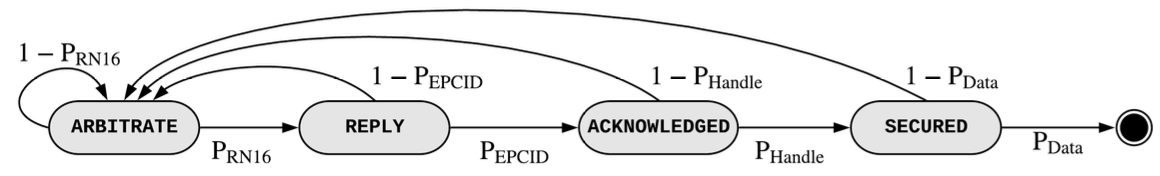

## 2-й сценарий:

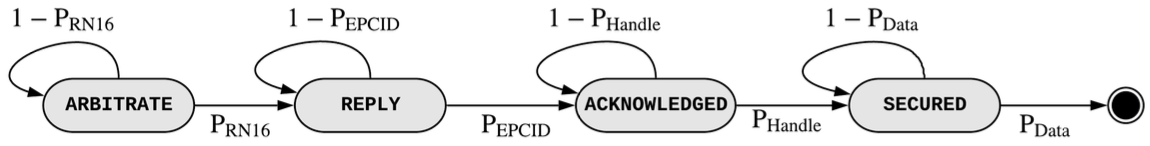

## 3-й сценарий:

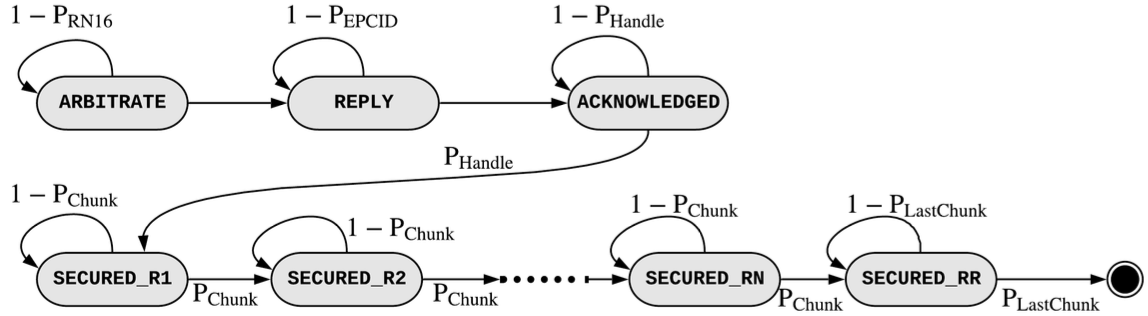

## 📦 Импорт необходимых модулей

In [1]:
from numpy.typing import NDArray
import matplotlib.pyplot as plt
import numpy as np

from pysim.models.rfid import channel
from pysim.models.rfid.params import default_params, inner_params
from pysim.models.tag_time.analitical_model import (
    convert_data_for_analitica, run_analitica
)
from pysim.models.tag_time.calculate_params import (
    build_messages_df, calculate_chunks,
    create_dicts, prepare_probs, prepare_times
)
from pysim.models.tag_time.cli import run_multiple_simulation
from pysim.models.tag_time.mc import run_multiple_models
from pysim.experiments.utility.channel_helper import (
    find_zones, get_pathloss, get_reader_rx,
    get_snr, get_tag_rx, get_tag_tx
)
from pysim.experiments.utility.graphs_style import (
    get_color, setup_matplotlib, savefig
)
import pysim.models.rfid.epcstd as epc

## 📌 Настройки моделирования

### 🔧 Константы

In [2]:
########################################################
# Количество моделируемых точек (= имитационок)
# Рекомендуемое количество от 15 до 30
POINTS_NUMBER: int = 30
# ------------------------------------------------------
DISTANCES = np.linspace(0, 15, num=POINTS_NUMBER)
# ------------------------------------------------------
# Количество повторов в одной симуляции (чем больше, тем выше точность)
# Рекомендуемое количество от 15_000 до 50_000
DEFAULT_MAX_TRANSMISSIONS: int = 15_000
# ------------------------------------------------------
delta: int = 1e-5 # с. Константа для расчёта времени
########################################################

### 🎛 Изменяемые параметры
Внимание! Для 1 и 2го сценария количество 'чанков' должно равняться единице!
Для 3го сценария количество чанков должно быть строго меньше минимального значения количества слов!

In [3]:
########################################################
# Параметры протокола
DR: epc.DivideRatio = inner_params.tag_params.dr
M: epc.TagEncoding = default_params.parse_tag_encoding(default_params.encoding)
TARI_US: float = default_params.tari
TRExt: bool = inner_params.tag_params.trext

SPEED = default_params.speed
trcal = epc.get_trcal(TARI_US)
########################################################
# ВЫБОР СЦЕНАРИЯ
# ------------------------------------------------------
# Номер сценария (1, 2, 3)
scenario: int = 3
# ------------------------------------------------------
PLOT_MODE = "DISTANCE" # "BER" или "DISTANCE"
# ------------------------------------------------------
# Количество передаваемых слов в состоянии Read
# Для каждого элемента кортежа запускается сет
# аналитических и Монте-Карло моделей.
# Соответственно, каждое значение отвечает за
# одну результирующую кривую. Длина кортежа =
# = количеству кривых на графике
# words_numbers: tuple = (2, 4, 6, 8)
words_numbers: tuple = (4, 8, 16, 32)
# ------------------------------------------------------
# ДЛЯ 1 И 2 СЦЕНАРИЕВ ДОЛЖНО РАВНЯТЬСЯ 1
# Количество чанков, на которые разбивается
# передаваемая информация в состоянии Read для
# 3 сценария
chunks_number: int = 1 if scenario in (1, 2) else 4
########################################################

## 🧮 Генерация команд и ответов
Результатом работы данного блока является объект типа list - params_list, содержащий объекты dict, соответствующие количеству моделируемых кривых. Для каждой кривой сохраняем свой набор параметров протокола RFID.
То есть
$$ params\_list = [dict_{Первая\_кривая}, ..., dict_{Последняя\_кривая}]$$

In [4]:
chunks_info_list = []
# Для каждой кривой создаём кортеж: (Слов в одном чанке, Слов в последнем чанке).
# Все кортежи добавляем в один лист.
for words_number in words_numbers:
    chunks_info_list.append(calculate_chunks(words_number, chunks_number))

params_list = []
# Индекс переменной с количеством слов в одном чанке
index_words_in_chunk = 0
# Индекс переменной с количеством слов в последнем чанке
index_words_in_last_chunk = 1
# Для каждой кривой генерируем набор RFID команд и ответов
for i in range(len(chunks_info_list)):
    params_list.append(
        build_messages_df(
            TARI_US, M, DR, TRExt, chunks_number,
            chunks_info_list[i][index_words_in_chunk],
            chunks_info_list[i][index_words_in_last_chunk]
        )
    )

## 📉 Расчёт вероятностей ошибок

Вероятность успешного перехода из одного состояния в другое определяется
исключительно ответами метки (так как во всём проекте сделано допущение, что
если метка оказалась в зоне чтения, то она гарантировано включается, корректно
получает команду считывателя и принимает участие в текущем раунде). Вероятность
перехода в следующее состояние равна вероятности успешного получения считывателем
ответа метки.
Вероятность определяется выражением:
$$ P_{msg} = (1 - BER)^{|msg|} $$
где msg - передаваемое сообщение, BER - вероятность битовой ошибки, |msg| - длина сообщения в битах

Результатом работы данного блока является объект типа list - probs_list. Количество элементов в probs_list соответствует количеству моделируемых кривых. Каждый элемент внутри probs_list - другой list, который сожержит столько элементов, сколько точек мы моделируем для одной кривой. Каждый такой элемент probs_list[i][j] является list из 4х элементов. Каждый элемент - вероятность перехода из одного состояния метки в другое.

То есть
$$ probs\_list = [[[P_{RN16}, P_{EPC}, P_{Handle}, P_{Data}]_0, ..., [P_{RN16}, P_{EPC}, P_{Handle}, P_{Data}]_{POINTS\_NUMBER-1}]]_{Первая\_кривая}, ..., [[], ..., []]_{Последняя\_кривая}] $$

In [5]:
def distance2ber(
    distances: NDArray[np.float64],
    speed: float = 0,
    m: epc.TagEncoding = default_params.parse_tag_encoding(default_params.encoding).value[1],
    trcal: float = epc.get_trcal(TARI_US),
    
) -> NDArray[np.float64]:
    """
    Перевод расстояния в метрах в значения BER

    Args:
        distances: массив с расстояниями между считывателем и меткой
        speed: скорость движения считывателя
    Returns:
        Массив значений BER
    """
    tag_accepted_power = [get_tag_rx(x, speed=speed, t=0) for x in distances]
    tag_radiated_power = [get_tag_tx(power) for power in tag_accepted_power]
    reader_accepted_power = [get_reader_rx(x, speed=speed, t=0, power=tag_power)
                             for (x, tag_power) in zip(distances, tag_radiated_power)]
    
    snr_on_reader = [get_snr(power, m, trcal) for power in reader_accepted_power]
    return np.array([channel.ber(snr) for snr in snr_on_reader])

In [6]:
if PLOT_MODE == "BER":
    BER = np.linspace(0, 0.01, num=POINTS_NUMBER)
elif PLOT_MODE == "DISTANCE":
    BER = distance2ber(DISTANCES, SPEED, M.value[1], trcal)

In [7]:
probs_list = []
for i in range(len(words_numbers)):
    probs_list.append(prepare_probs(params_list[i], chunks_number, BER, POINTS_NUMBER))

## ⏱ Расчёт временных задержек

Время перехода из одного состояния в другое вычисляется по формулам:
$$T_{Arbitrate} = T_{Query} + T_1 + T_{RN16} + T_2 + 2\delta$$ 
$$T_{Reply} = T_{Ack} + T_1 + T_{EPC} + T_2 + 2\delta$$
$$T_{Acknowledged} = T_{Req_RN} + T_1 + T_{Handle} + T_2 + 2\delta$$
$$T_{Secured} = T_{Read} + T_1 + T_{Data} + T_2 + 2\delta$$
$$T_{Secured.Ri} = T_{Read} + T_1 + T_{Chunk.i} + T_2 + 2\delta$$
$$T_{Secured.LC} = T_{Read} + T_1 + T_{Last.Chunk} + T_2 + 2\delta$$
где $T_{msg.name}$ - длительность команды считывателя или ответа метки, 
$T_{Secured.Ri}$ - длительность для i-го 'чанка', 
$T_{Secured.ДС}$ - длительность последнего 'чанка', 
$T_1$ и $T_2$ - параметры, определяемые протоколом RFID (в блокноте рассчитываются с помощью функций), 
$\delta$ - время распространения сигнала (в блокноте определяется как взятая наобум константа)

Результатом работы данного блока является объект типа list - t_list. Его структура полностью аналогична probs_list. Каждый элемент является временем нахождения в конкретном состоянии

In [8]:
t_list = []
for i in range(len(words_numbers)):
    t_list.append(prepare_times(params_list[i], probs_list[i], chunks_number))

## 🎲 Имитация методом Монте-Карло

Данный блок включает два независимых способа имитационного моделирования времени чтения метки:

- 🔁 **Метод с использованием матриц вероятностей перехода**: Быстрый, лаконичный и методологически корректный подход. Он использует цепи Маркова и позволяет эффективно рассчитать среднее время чтения.

- 🧱 **Альтернативная симуляция на основе модели tag_time**: Более наглядная, но медленная и сложная для восприятия. Была реализована первой, за её основу взята модель **pingpong**. Подходит для сравнения и подтверждения результатов.

Оба метода используются для расчёта одного и того же показателя — времени чтения метки — и обеспечивают перекрёстную проверку результатов.

### 🔁 Модель с матрицами перехода

In [9]:
mc_res_list = []
for i in range(len(words_numbers)):
    mc_res_list.append(
        run_multiple_models(scenario, probs_list[i], t_list[i], DEFAULT_MAX_TRANSMISSIONS)
)

### 🧱 Модель на основе tag_time

#### 📦 Подготовка данных для имитационных моделей

Результатом работы данного блока является объект типа list - dicts_list. Количество элементов в листе соответсвует количеству моделируемых кривых. Каждый элемент - dict содержащит наборы данных для параллельного запуска сета моделей Монте-Карло. Получается, что один словарь - это данные для одного сета парралельно вычисляемых моделей Монте-Карло. В результате получаем одну кривую. Лист словарей - это данные для последовательно вычисляемых сетов моделей Монте-Карло. В результате получаем несколько кривых на одном изображении.

In [10]:
dicts_list = []
for i in range(len(words_numbers)):
    dicts_list.append(create_dicts(probs_list[i], t_list[i], chunks_number, scenario, DEFAULT_MAX_TRANSMISSIONS))

#### ▶️ Запуск имитационных моделей

In [11]:
def old_simulation(
    words_numbers,
    dicts_list,
    compute: bool = False
) -> list:
    """
    Запуск имитационного моделирования старым и долгим способом.

    Args:
        words_numbers:
        dicts_list:
        compute: запускать ли симуляцию

    Returns:
        pp_res_list: лист с результатами симуляции        
    """
    pp_res_list = []
    if compute:
        for i in range(len(words_numbers)):
            # Результат работы одного пакета имитационок (одна кривая)
            one_packet = run_multiple_simulation(dicts_list[i])
            res = []
            for i in one_packet:
                res.append(i.sim_time/DEFAULT_MAX_TRANSMISSIONS*1_000) # миллисекунды
            pp_res_list.append(res)

    return pp_res_list

pp_res_list = old_simulation(words_numbers, dicts_list, compute = False)

## 📐 Запуск аналитических моделей

In [12]:
phases_list = []
for i in range(len(words_numbers)):
    phases_list.append(convert_data_for_analitica(probs_list[i], t_list[i]))

analit_res_list = []
for i in range(len(words_numbers)):
    analit_res_list.append(run_analitica(scenario, phases_list[i], chunks_number))

## 📊 Оценка погрешности

In [13]:
error_values = [abs((j-k)/j*100) for k, j in zip(analit_res_list[0], mc_res_list[0])]
print(f'Разница между аналитикой и симуляцией = {sum(error_values)/len(error_values)} %')

Разница между аналитикой и симуляцией = 0.030668643018361086 %


## 🖼 Построение графиков

In [14]:
setup_matplotlib()
DIRECTORY = 'tag_time' # Название директории, в которой будут сохраняться изображения

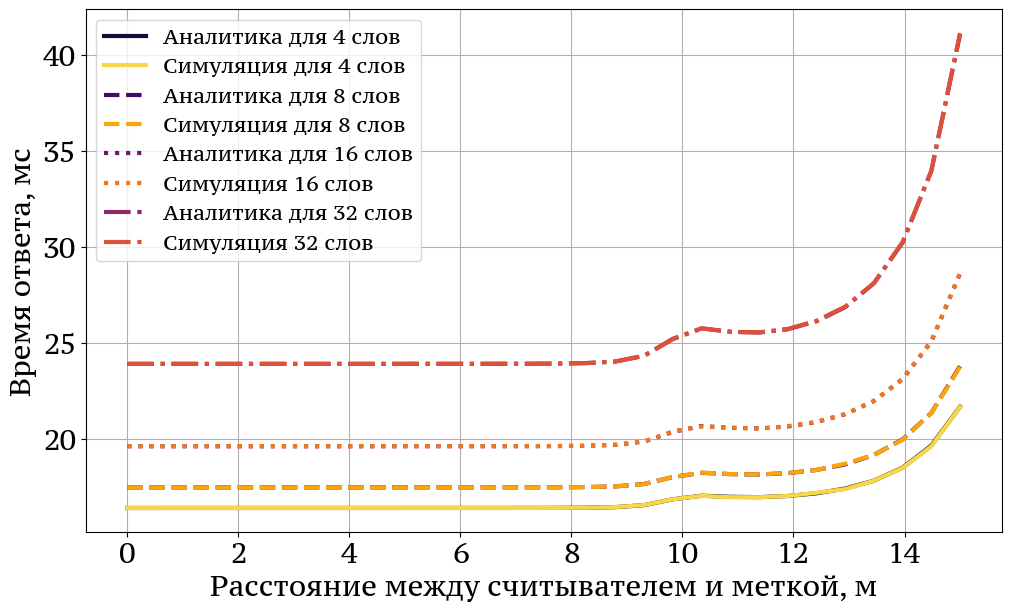

In [15]:
fig, ax = plt.subplots(figsize=(10, 6), layout="constrained")
if PLOT_MODE == "BER":
    ox_axis = BER
    ax.set_xlabel("Вероятность битовой ошибки", fontsize=20)
elif PLOT_MODE == "DISTANCE":
    ox_axis = DISTANCES
    ax.set_xlabel("Расстояние между считывателем и меткой, м", fontsize=20)
else:
    raise f"Недопустимое режим отрисовки графиков: {PLOT_MODE}"

ax.set_ylabel("Время ответа, мс", fontsize=20)
plt.tick_params(axis="both", which="major", labelsize=20)
# ax.set_title(f'Reading time for {scenario}st scenario')

# 1я пара
# --------------------------------------
ax.plot(
    ox_axis, analit_res_list[0],
    linewidth=3, linestyle="-",
    label=f"Аналитика для {words_numbers[0]} слов",
    color=get_color(0.1)
)
ax.plot(
    ox_axis, mc_res_list[0],
    linewidth=3, linestyle="-",
    label=f"Симуляция для {words_numbers[0]} слов",
    color=get_color(0.9)
)
# 2я пара
# --------------------------------------
ax.plot(
    ox_axis, analit_res_list[1],
    linewidth=3, linestyle="--",
    label=f"Аналитика для {words_numbers[1]} слов",
    color=get_color(0.2)
)

ax.plot(
    ox_axis, mc_res_list[1],
    linewidth=3, linestyle="--",
    label=f"Симуляция для {words_numbers[1]} слов",
    color=get_color(0.8)
)
# 3я пара
# --------------------------------------
ax.plot(
    ox_axis, analit_res_list[2],
    linewidth=3, linestyle="dotted",
    label=f"Аналитика для {words_numbers[2]} слов",
    color=get_color(0.3)
)
ax.plot(
    ox_axis, mc_res_list[2],
    linewidth=3, linestyle='dotted',
    label=f"Симуляция {words_numbers[2]} слов",
    color=get_color(0.7)
)
# 4я пара
# --------------------------------------
ax.plot(
    ox_axis, analit_res_list[3],
    linewidth=3, linestyle="dashdot",
    label=f"Аналитика для {words_numbers[3]} слов",
    color=get_color(0.4)
)
ax.plot(
    ox_axis, mc_res_list[3],
    linewidth=3, linestyle="dashdot",
    label=f"Симуляция {words_numbers[3]} слов",
    color=get_color(0.6)
)
# --------------------------------------
plt.legend(prop={"size":15})
plt.grid()
# Для большого объёма передаваемых данных рекомендуется добавлять к названию суффикс "_large"
savefig(name=f"{scenario}_scenario_dist_large", directory=DIRECTORY)